# Redborder Wrapped

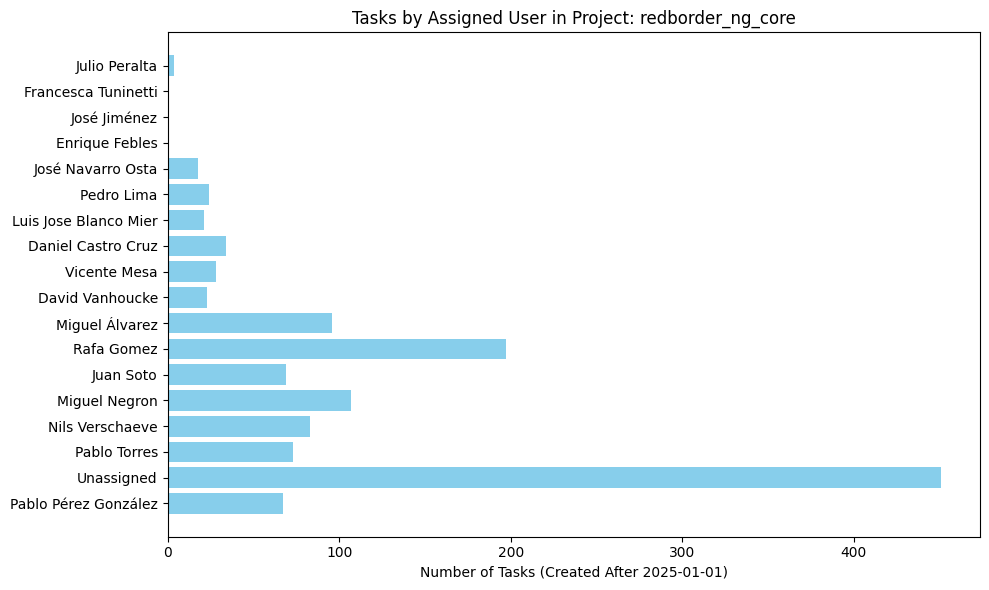

In [1]:
# Import libraries
import requests
from dotenv import load_dotenv
import os
import urllib3
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import pandas as pd

# Disable warnings for self-signed certs
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Load .env
load_dotenv()
API_KEY = os.getenv('REDMINE_API_KEY')

# Config
REDMINE_URL = 'https://redmine.redborder.lan'
PROJECT_ID = 'redborder_ng_core'
LIMIT = 100
offset = 0
all_issues = []

headers = {
    'X-Redmine-API-Key': API_KEY
}

# 🔄 Fetch all issues with pagination
while True:
    params = {
        'project_id': PROJECT_ID,
        'status_id': '*',
        'limit': LIMIT,
        'offset': offset
    }
    response = requests.get(f'{REDMINE_URL}/issues.json', params=params, headers=headers, verify=False)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code} - {response.text}")
        break

    data = response.json()
    issues = data.get('issues', [])
    all_issues.extend(issues)

    if len(issues) < LIMIT:
        break  # no more pages
    offset += LIMIT

# 🔁 Filter issues created after a specific date
date_cutoff = datetime.strptime('2025-01-01', '%Y-%m-%d')
filtered_issues = []

for issue in all_issues:
    created_str = issue.get('created_on')
    if created_str:
        created_at = datetime.strptime(created_str, '%Y-%m-%dT%H:%M:%SZ')
        if created_at > date_cutoff:
            filtered_issues.append(issue)

# 📊 Count issues by assigned user
assigned_counts = Counter()

for issue in filtered_issues:
    assigned_to = issue.get('assigned_to', {}).get('name', 'Unassigned')
    assigned_counts[assigned_to] += 1

# Plotting
names = list(assigned_counts.keys())
counts = list(assigned_counts.values())

plt.figure(figsize=(10, 6))
plt.barh(names, counts, color='skyblue')
plt.xlabel('Number of Tasks (Created After 2025-01-01)')
plt.title(f'Tasks by Assigned User in Project: {PROJECT_ID}')
plt.tight_layout()
plt.show()